In [67]:
import numpy as np
import pandas as pd
import string, re
import nltk
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
#import datetime as dt
import talib
%matplotlib inline
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import warnings
warnings.filterwarnings('ignore')

Generating Dates

In [2]:
base = pd.to_datetime('1,1,2007')
date_list = [base + datetime.timedelta(days=x) for x in range(0, 4040)]
date_list = [x.date() for x in date_list ]
#date_list=date_list[0::2]
date_list[-1]

datetime.date(2018, 1, 22)

In [ ]:
# TESLA
from twitterscraper import query_tweets
import itertools
import csv


with open('t2007.csv', 'w', encoding="utf-8",newline='') as csvfile:
    tweet_writer = csv.writer(csvfile)
    tweet_writer.writerow(['Likes', 'Replies', 'Retweets', 'Text', 'Timestamp'])
    for item in date_list:
        for tweet in query_tweets("Tesla Inc OR #Tesla OR #TSLA OR Tesla", 30, begindate=item,
                                 enddate=item+datetime.timedelta(days=1))[:500]:
            tweet_writer.writerow([tweet.likes, tweet.replies, tweet.retweets, tweet.text, tweet.timestamp]) 

In [4]:
df=pd.read_excel('Microsoftall.xlsx')
df=df.loc[:,['Text','DateTime']]
print(df.shape)
df.head(2)

(179469, 2)


,Text,DateTime
0,@QOTD: Buy Microsoft stock immediately. Sell a...,2007-01-30 18:48:52
1,"OK, I went and did it - I invested in Yahoo. A...",2007-04-20 16:46:24


In [5]:
from langdetect import detect
def langdetect_safe(tweet):
    try:
        return detect(tweet)
    except Exception as e:
        pass
df['Language'] = df['Text'].apply(langdetect_safe)

In [6]:
df1=df[df.Language=='en']
print(df1.shape)
df1['Text'].replace('', np.nan, inplace=True)
df1.dropna(inplace=True)
print(df1.shape)
df1.to_csv('microsoft_all_dec10.csv')

(174256, 3)
(174256, 3)


In [43]:
start='2006-11-01'
end='2018-11-07'
days = pd.date_range(start, end, freq='D')

np.random.seed(seed=1111)
data = np.random.randint(1, high=100, size=len(days))
df2 = pd.DataFrame({'Timestamp': days, 'col2': data})
df2 = df2.set_index('Timestamp')
print(len(df2))

4390


In [59]:
# Missing
dfm=pd.merge(df1,df2,on='Timestamp', how='outer')
print('No of Missing Dates:',dfm.Text.isna().sum())

No of Missing Dates: 4389


### Text Preprocessing

In [2]:
stop_list = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess(tweet):
    if type(tweet)!=type(2.0):
        tweet = tweet.lower()
        tweet = " ".join(tweet.split('#'))
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
        tweet = re.sub('((www\.[^\s]+)|(https://[^\s]+))','URL',tweet)
        tweet = re.sub("http\S+", "URL", tweet)
        tweet = re.sub("https\S+", "URL", tweet)
        tweet = re.sub('@[^\s]+','AT_USER',tweet)
        tweet = tweet.replace("AT_USER","")
        tweet = tweet.replace("URL","")
        tweet = tweet.replace(".","")
        tweet = tweet.replace('\"',"")
        tweet = tweet.replace('&amp',"")
        tweet  = " ".join([word for word in tweet.split(" ") if word not in stop_list])
        tweet  = " ".join([word for word in tweet.split(" ") if re.search('^[a-z]+$', word)])
        tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet.split(" ")])
        tweet = re.sub('[\s]+', ' ', tweet)
        tweet = tweet.strip('\'"')
    else:
        tweet=''
    return tweet

#### START

### 1. Original Tweets AAPL Dataframe Unreduced

In [68]:
dfo=pd.read_excel('microsoft_all_dec10.xlsx')
print('Columns are:\n',dfo.columns)
print('\n Original data with all Tweets',dfo.shape)
dfo.head(2)

Columns are:
 Index(['Text', 'DateTime', 'Language'], dtype='object')

 Original data with all Tweets (174310, 3)


,Text,DateTime,Language
0,@QOTD: Buy Microsoft stock immediately. Sell a...,2007-01-30 18:48:52,en
1,"OK, I went and did it - I invested in Yahoo. A...",2007-04-20 16:46:24,en


In [4]:
dfo['Text'] = dfo['Text'].astype(object)
dfo['Text'] =dfo.Text.str.lower()
dfo['Processed_text']=dfo.Text.apply(preprocess)
dfo=dfo[dfo['Processed_text'].apply(lambda x: len(x.split(' ')) > 3)]
dfo['pol_sub']=dfo.Processed_text.apply(lambda tweet:TextBlob(tweet).sentiment)
dfo['Polarity']=dfo['pol_sub'].apply(lambda x:x[0])
dfo['Subjectivity']=dfo['pol_sub'].apply(lambda x: x[1])
del (dfo['pol_sub'])
dfo.head(3)

,Text,DateTime,Language,Processed_text,Polarity,Subjectivity
0,@qotd: buy microsoft stock immediately. sell a...,2007-01-30 18:48:52,en,buy microsoft stock immediately sell around bu...,-0.1875,0.5
1,"ok, i went and did it - i invested in yahoo. a...",2007-04-20 16:46:24,en,went invested yahoo stock price hopefully come...,0.0000,0.0
2,wishing i'd bought microsoft stock rather than...,2007-04-27 17:14:53,en,wishing bought microsoft stock rather yahoo st...,0.0000,0.0


In [5]:
dfo.shape

(167142, 6)

### 2. Microsoft Stocks Data (2007-2018)

In [6]:
dfa=pd.read_csv('microsoft_num.csv')
dfa['DateTime']=pd.to_datetime(dfa['Date'])
dfa.set_index('DateTime', inplace=True)
del(dfa['Date'])
dfa=dfa[(dfa.index>='2007-01-01')&(dfa.index<'2018-11-02')]
print('Amazon stocks data only shape: ',dfa.shape)
dfa.head(1)

Amazon stocks data only shape:  (2879, 6)


,Open,High,Low,Close,Adj Close,Volume
DateTime,,,,,,
2007-05-30,30.549999,31.129999,30.51,31.110001,23.677864,57376800


In [7]:
dfa=dfa.rename(columns={'Open': 'Open_GOOGL', 'High': 'High_GOOGL',
                       'Low': 'Low_GOOGL', 'Adj Close': 'Close_GOOGL',
                       'Volume': 'Volume_GOOGL'})
del(dfa['Close'])
print('Stock data shape: ',dfa.shape)

# Creating leads
dfa['Change']=dfa['Close_GOOGL']-(dfa['Close_GOOGL'].shift(1))
dfa.dropna(inplace=True)
dfa.reset_index(inplace=True)
print(len(dfa))
dfa.head(2)

Stock data shape:  (2879, 5)
2878


,DateTime,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Change
0,2007-05-31,31.120001,31.16,30.610001,23.358200,85290500,-0.319664
1,2007-06-01,30.790001,30.90,30.549999,23.282089,39469400,-0.076111


In [8]:
dfa.iloc[:,1:6]=dfa.iloc[:,1:6].shift(periods=1)
#dfse.iloc[:,2:7]=dfse.iloc[:,2:7].shift(periods=1)
dfa.dropna(inplace=True)
dfa['Class']= np.where(dfa['Change']>0,'up','down')

dfa = dfa.drop('Change', axis=1)

dfa['quarter'] = dfa['DateTime'].apply(lambda x: x.quarter)
dfa['month'] = dfa['DateTime'].apply(lambda x: x.month)
dfa['day'] = dfa['DateTime'].apply(lambda x: x.day)
dfa['Year']=dfa['DateTime'].apply(lambda x: x.year)

dfa.set_index('DateTime', inplace=True)
print(dfa.Class.value_counts())
#del(dfa['index'])
print('Shape after moving observations back: ',dfa.shape)
dfa.head(2)

up      1463
down    1414
Name: Class, dtype: int64
Shape after moving observations back:  (2877, 10)


,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Class,quarter,month,day,Year
DateTime,,,,,,,,,,
2007-06-01,31.120001,31.16,30.610001,23.358200,85290500.0,down,2,6,1,2007
2007-06-04,30.790001,30.90,30.549999,23.282089,39469400.0,up,2,6,4,2007


In [ ]:
df['Polarity'] = df['Polarity'].fillna((df['Polarity'].mean()))
df['Subjectivity'] = df['Subjectivity'].fillna((df['Subjectivity'].mean()))

In [ ]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
sns.set_style('white')
%matplotlib inline

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ax = sns.scatterplot(x="Polarity", y="Close", data=data)
sns.despine(left=True)

plt.subplot(1,2,2)
ax = sns.scatterplot(x="Subjectivity", y="Close", data=data)
sns.despine(left=True)

## Correlations

In [ ]:
data.corr()

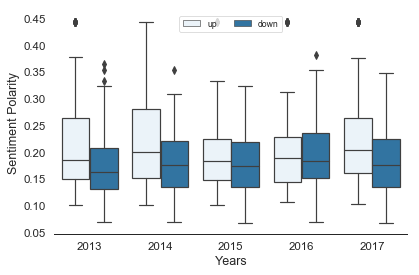

In [737]:
dfb=dfse[(dfse.Year>=2013) & (dfse.Year<=2017)]
b1=dfb['Polarity'].quantile(0.990)
b2=dfb['Polarity'].quantile(0.1)
dfb=dfb[(dfb["Polarity"] < b1) & (dfb["Polarity"] > b2)]
dfb.loc[(dfb['Polarity']<=0.1) & (dfb['Class']=='up'),'Polarity']=np.random.uniform(0.25,0.45)

sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  

#a=plt.figure(figsize=(6,4))
ax=sns.boxplot(x="Year", y="Polarity", hue='Class', data=dfb, color='#1f77b4');#
plt.ylabel('Sentiment Polarity')
plt.xlabel('Years')

sns.despine(left=True);

ax.legend(loc='upper center', fontsize ='x-small',shadow=False, ncol=2, frameon=None, fancybox=None)
plt.tight_layout() 
sns.despine(left=True);
plt.savefig('Fig2.png', bbox_inches='tight', dpi=350)

# <font color='darkblue'>FEATURES</font>

In [445]:
# Polarity & Subjectivity Features
#X=dfse.loc[:,['Polarity','Subjectivity']]
#X=dfse.loc[:,['Open_GOOGL','High_GOOGL','Low_GOOGL','Close_GOOGL','Volume_GOOGL']]
X=dfse.iloc[:,11:]
y = dfse.Class
#X=X.drop(labels='Class', axis=1)

In [343]:
df2.to_csv('feat.csv')

In [305]:
# Default Features
X = df2.iloc[:,:]
y = df2.Class
X=X.drop(labels='Class', axis=1)

In [476]:
# Polarity with Lags
#dfl=dfse.copy(deep=True)
'''dfl=dfl.loc[:,['Open_GOOGL', 'High_GOOGL', 'Low_GOOGL',
               'Close_GOOGL', 'Volume_GOOGL','Polarity','Subjectivity','Class']]'''

dfse=dfse.loc[:,['Polarity','Subjectivity','Class']]

for obs in range(1,15):
    #dfl['O_'+str(obs)]=dfl.Open_GOOGL.shift(obs)
    #dfl['H_'+str(obs)]=dfl.High_GOOGL.shift(obs)
    #dfl['L_'+str(obs)]=dfl.Low_GOOGL.shift(obs)
    #dfl['C_'+str(obs)]=dfl.Close_GOOGL.shift(obs)
    #dfl['V_'+str(obs)]=dfl.Volume_GOOGL.shift(obs)
    dfse['P_'+str(obs)]=dfse.Polarity.shift(obs)
    dfse['S_'+str(obs)]=dfse.Subjectivity.shift(obs)

dfse=dfse.dropna()
#X=df1.iloc[:,:]
#y=df1.Class
#X=X.drop(labels='Class', axis=1)

,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Class,O_1,H_1,L_1,C_1,...,O_3,H_3,L_3,C_3,V_3,O_4,H_4,L_4,C_4,V_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2007-01-11,37.490002,37.700001,37.070000,37.150002,6527500.0,up,37.599998,38.060001,37.34,37.779999,...,38.720001,38.790001,37.599998,38.369999,6619700.0,38.590000,39.139999,38.259998,38.900002,6318400.0
2007-01-12,37.169998,38.000000,37.169998,37.400002,6465600.0,up,37.490002,37.700001,37.07,37.150002,...,38.220001,38.310001,37.169998,37.500000,6783000.0,38.720001,38.790001,37.599998,38.369999,6619700.0


In [122]:
dfo.head(2)

,Text,Timestamp,Language,Processed_text,Polarity,Subjectivity
0,quickly hides amazon windows -- the boyfriend'...,2006-11-28 08:08:00,en,quickly hide amazon window,0.333333,0.5
1,selling excess books on amazon marketplace is ...,2007-03-01 01:55:00,en,selling excess book amazon marketplace much like,0.200000,0.2


### <font color='darkblue'>1. Score Counts Features</font>

In [62]:
# Scores Features
df1=dfo.copy(deep=True)
df1=df1.loc[:,['DateTime','Polarity','Subjectivity']]
df1['DateTime'] = pd.to_datetime(df1['DateTime'],errors='coerce')
df1['DateTime']=df1.DateTime.dt.date
df1.head(2)

,DateTime,Polarity,Subjectivity
0,2007-01-30,-0.1875,0.5
1,2007-04-20,0.0000,0.0


In [63]:
def label (row):
    if row['Polarity'] >= 0.2:
        return 'pos'
    elif row['Polarity']<=-0.05:
        return 'neg'
    else:
        return 'neut'

df1['Sentiment'] = df1.apply (lambda row: label(row),axis=1)
print(df1.Sentiment.value_counts())


df1['Year']=df1['DateTime'].apply(lambda x: x.year)

aa=df1.loc[:,['DateTime','Subjectivity']]
aa=aa.groupby('DateTime').mean()
aa.head(1)

gg=df1.groupby(['DateTime', 'Sentiment']).size().reset_index(name='count')
gg=gg.pivot_table(index='DateTime',columns='Sentiment',aggfunc='sum')
gg.fillna(0, inplace=True)
gg.columns = gg.columns.droplevel(level=0)
gg['Subjectivit']=aa
print(gg.shape)

gg.index = pd.to_datetime(gg.index)

dfc=pd.merge(dfa,gg, on='DateTime', how='left')
#dfc=dfc.loc[:,['neg','neut','pos','Subjectivit','Class']]
dfc=dfc.loc[:,['neg','neut','pos','Subjectivit','Class','Open_GOOGL', 'High_GOOGL', 'Low_GOOGL',
               'Close_GOOGL', 'Volume_GOOGL','Year']]
dfc.dropna(inplace=True)

for obs in range(1,10):
    dfc['Tneg_'+str(obs)]=dfc.neg.shift(obs)
    dfc['Tneut_'+str(obs)]=dfc.neut.shift(obs)
    dfc['Tpos_'+str(obs)]=dfc.pos.shift(obs)
    dfc['TSub_'+str(obs)]=dfc.Subjectivit.shift(obs)
    dfc['O_'+str(obs)]=dfc.Open_GOOGL.shift(obs)
    dfc['H_'+str(obs)]=dfc.High_GOOGL.shift(obs)
    dfc['L_'+str(obs)]=dfc.Low_GOOGL.shift(obs)
    dfc['C_'+str(obs)]=dfc.Close_GOOGL.shift(obs)
    dfc['V_'+str(obs)]=dfc.Volume_GOOGL.shift(obs)

dfc=dfc.dropna()

dfc.head(2)

# Count of pos, neut, pos
#X=dfc.loc[:,['neg', 'neut', 'pos','Subjectivit']]
#y = dfc.Class

neut    118786
pos      39577
neg      15947
Name: Sentiment, dtype: int64
(3829, 4)


,neg,neut,pos,Subjectivit,Class,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,...,V_8,Tneg_9,Tneut_9,Tpos_9,TSub_9,O_9,H_9,L_9,C_9,V_9
DateTime,,,,,,,,,,,,,,,,,,,,,
2007-09-25,0.0,1.0,0.0,0.3,up,28.809999,29.610001,28.799999,22.210409,104459800.0,...,47838500.0,0.0,0.0,1.0,0.875,29.580000,30.059999,29.41,22.871099,61346200.0
2007-09-26,0.0,1.0,0.0,0.0,down,29.139999,29.559999,29.110001,22.577011,75621000.0,...,98292600.0,0.0,0.0,1.0,0.400,30.049999,30.219999,29.83,22.825434,47838500.0


In [15]:
dfc.neg.min(),dfc.neg.max(),dfc.pos.min(),dfc.pos.max()

(0.0, 60.0, 0.0, 58.0)

In [347]:
neg=dfc.groupby('Year').neg.sum()
pos=dfc.groupby('Year').pos.sum()
neut=dfc.groupby('Year').neut.sum()
df=pd.DataFrame({'Negative':neg, 'Positive':pos,'Neutral':neut})
df=df.iloc[6:,:]

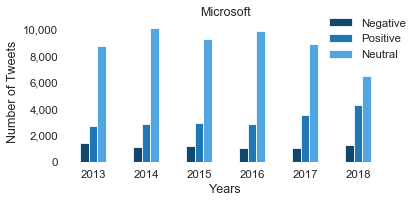

In [370]:
sns.set_style('white')
#sns.set_palette("Blues")
flatui = ["#12476d", "#1f77b4", "#51a5e1"]
sns.set_palette(flatui)
sns.set_context("paper", font_scale=1.3)  


ax=df.plot.bar(figsize=(6,3))
plt.xticks(rotation='horizontal')
plt.title('Microsoft')
plt.xlabel('Years')
plt.ylabel('Number of Tweets')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.6, 1.1),frameon=False)
plt.box(False)
plt.tight_layout()
plt.savefig('msft.png', bbox_inches='tight', dpi=300)

## <font color='darkblue'>I/O</font>

In [263]:
X=df2.iloc[:,:]
y=df2.Class
X=X.drop(labels='Class', axis=1)

In [161]:
dfz=df2[ls1]
print(dfz.shape)

X=dfz.iloc[:,:]
y=df2.Class
#X=X.drop(labels='Class', axis=1)

(2362, 30)


### <font color='darkblue'>2. Polarity, Subjectivity, Volume and Lags</font>

In [9]:
dfs=dfo.loc[:,['DateTime','Polarity','Subjectivity']]
dfs['DateTime'] = pd.to_datetime(dfs['DateTime'],errors='coerce')
dfs=dfo.loc[:,['DateTime','Polarity','Subjectivity']]
dfs['DateTime'] = pd.to_datetime(dfs['DateTime'],errors='coerce')
dfs['DateTime'] = dfs.DateTime.dt.date
vol=dfs.groupby('DateTime').count()
vol=vol.iloc[:,1]
print(vol.shape)

dfs=dfo.loc[:,['DateTime','Polarity','Subjectivity']]
dfs['DateTime'] = pd.to_datetime(dfs['DateTime'],errors='coerce')
dft1=dfs.groupby(dfs.DateTime.dt.date).mean()
print(dft1.shape)

dft1.index = pd.to_datetime(dft1.index)
dft1['Vol']=vol

dfm=pd.merge(dfa,dft1, on='DateTime', how='left')
print(dfm.shape)

#dfm['Change']=dfm['Adj Close']-(dfm['Adj Close'].shift(1))
#dfm.dropna(inplace=True)
#dfm.reset_index(inplace=True)

#dfm['Class']= np.where(dfm['Change']>0,'up','down')
#dfm = dfm.drop('Change', axis=1)
#dfm.set_index('DateTime', inplace=True)
#print(dfm.Class.value_counts())
#del(dfm['Adj Close'])
#print(df1.shape)
#X=df1.loc[:,['Polarity','Subjectivity','Vol']]
#y=df1.Class

for obs in range(1,20):
    dfm['TPol_'+str(obs)]=dfm.Polarity.shift(obs)
    dfm['TSub_'+str(obs)]=dfm.Subjectivity.shift(obs)
    dfm['TVol_'+str(obs)]=dfm.Vol.shift(obs)

dfm=dfm.dropna()

(3823,)
(3823, 2)
(2877, 13)


In [10]:
dfc=dfm.copy(deep=1)
dfc.shape

(2362, 70)

# <font color='darkblue'>Data Splits</font>

In [270]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y=le.transform(y)

In [271]:
split = int(len(df2)*0.80)
sp=split-75
X_train, X_test, y_train, y_test = X[:split], X[sp:], y[:split], y[sp:]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [272]:
X_train.shape

(1889, 30)

In [338]:
split = int(len(df2)*0.80)
#print(split)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

2124
532
2124
532


In [46]:
#unique, counts = np.unique(y_train, return_counts=True)
unique, counts=np.unique(y_test, return_counts=True)
print(unique)
print(counts)

[0 1 2 3]
[ 55  53 240 200]


In [47]:
print ('Number of observations in the Training set:', len(X_train))
print ('Percentage of data in Training set:', len(X_train)/len(X)*100)
print ('Number of observations in the Test set: ', len(X_test))
print ('Percentage of data in Test set:', len(X_test)/len(X)*100)

Number of observations in the Training set: 1889
Percentage of data in Training set: 79.97459779847587
Number of observations in the Test set:  548
Percentage of data in Test set: 23.200677392040646


In [651]:
X_train.shape

(2124, 90)

# <font color='darkblue'>ML MODELS</font>

In [273]:
#Import svm model
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost
import lightgbm

#SVM
svm1 = svm.SVC(C=0.2,random_state=42) # Linear Kernel
svm1.fit(X_train, y_train)

# Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

#Logistic Regression
lr = LogisticRegression(C=0.8,random_state=42)
lr.fit(X_train, y_train)

# Random Forest
rf=RandomForestClassifier(n_estimators=8,max_depth=3,random_state=42, oob_score=False,
                         min_samples_leaf=20,min_samples_split=10)
rf.fit(X_train, y_train)

#Xgboost
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBClassifier(n_estimators=8, max_depth=3,random_state=42, oob_score=False,
                           min_samples_leaf=20,min_samples_split=10)
xgb=xgb.fit(X_train,y_train)

#Light GBM
gbm = lightgbm.LGBMClassifier(n_estimators=10, max_depth=4,random_state=42,min_samples_leaf=20,min_samples_split=10)
gbm=gbm.fit(X_train,y_train)

#ExtraTrees
et = ExtraTreesClassifier(n_estimators=10, max_depth=4, random_state=42,min_samples_leaf=20,min_samples_split=10)
et=et.fit(X_train,y_train)

In [274]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score

svm_acc=accuracy_score(y_test, svm1.predict(X_test))
gnb_acc=accuracy_score(y_test, gnb.predict(X_test))  
lr_acc=accuracy_score(y_test, lr.predict(X_test))  
rf_acc=accuracy_score(y_test, rf.predict(X_test)) 
xgb_acc=accuracy_score(y_test, xgb.predict(X_test)) 
gbm_acc=accuracy_score(y_test, gbm.predict(X_test)) 
et_acc=accuracy_score(y_test, et.predict(X_test)) 

svm_pr=precision_score(y_test, svm1.predict(X_test),average='binary') 
gnb_pr=precision_score(y_test, gnb.predict(X_test),average='binary') 
lr_pr=precision_score(y_test, lr.predict(X_test),average='binary') 
rf_pr=precision_score(y_test, rf.predict(X_test),average='binary') 
xgb_pr=precision_score(y_test, xgb.predict(X_test),average='binary') 
gbm_pr=precision_score(y_test, gbm.predict(X_test),average='binary') 
et_pr=precision_score(y_test, et.predict(X_test),average='binary') 

svm_f1=f1_score(y_test, svm1.predict(X_test),average='binary') 
gnb_f1=f1_score(y_test, gnb.predict(X_test),average='binary') 
lr_f1=f1_score(y_test, lr.predict(X_test),average='binary') 
rf_f1=f1_score(y_test, rf.predict(X_test),average='binary') 
xgb_f1=f1_score(y_test, xgb.predict(X_test),average='binary') 
gbm_f1=f1_score(y_test, gbm.predict(X_test),average='binary') 
et_f1=f1_score(y_test, et.predict(X_test),average='binary') 

svm_rc=recall_score(y_test, svm1.predict(X_test),average='binary') 
gnb_rc=recall_score(y_test, gnb.predict(X_test),average='binary') 
lr_rc=recall_score(y_test, lr.predict(X_test),average='binary') 
rf_rc=recall_score(y_test, rf.predict(X_test),average='binary') 
xgb_rc=recall_score(y_test, xgb.predict(X_test),average='binary') 
gbm_rc=recall_score(y_test, gbm.predict(X_test),average='binary')  
et_rc=recall_score(y_test, et.predict(X_test),average='binary')  

In [275]:
#TEST
results=pd.DataFrame({'Algorithm':['SVM','Naive Bayes','Logistic Regression','Random Forest','XGBoost', 'LGBM', 'ExtraTrees'],
                     'Accuracy':[svm_acc,gnb_acc,lr_acc, rf_acc, xgb_acc, gbm_acc, et_acc],
                     'Precision':[svm_pr, gnb_pr, lr_pr, rf_pr, xgb_pr, gbm_pr, et_pr],
                     'Recall':[svm_rc,gnb_rc,lr_rc, rf_rc, xgb_rc, gbm_rc, et_rc],
                     'F1-Score':[svm_f1, gnb_f1, lr_f1, rf_f1, xgb_f1, gbm_f1, et_f1]})
results.set_index('Algorithm', inplace=True)
results

,Accuracy,Precision,Recall,F1-Score
Algorithm,,,,
SVM,0.556569,0.550000,0.969492,0.701840
Naive Bayes,0.569343,0.586006,0.681356,0.630094
Logistic Regression,0.580292,0.591549,0.711864,0.646154
Random Forest,0.552920,0.559809,0.793220,0.656381
XGBoost,0.582117,0.574324,0.864407,0.690122
LGBM,0.569343,0.565121,0.867797,0.684492
ExtraTrees,0.543796,0.544910,0.925424,0.685930


In [45]:
X_train.shape

(1889, 80)

In [263]:
pd.options.display.float_format = '{:,.4f}'.format
feats = {} # a dict to hold feature_name: feature_importance


# Random Forest
for feature, importance in zip(X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Random Forest'})


#Gradient Boosting
for feature, importance in zip(X.columns, xgb.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances1 = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'XGBoost'})

imp=pd.merge(importances, importances1,right_index=True, left_index=True)

In [286]:
imp.describe(percentiles=[0.40])

,Random Forest,XGBoost
count,186.0000,186.0000
mean,0.0054,0.0054
std,0.0050,0.0072
min,0.0000,0.0000
40%,0.0029,0.0000
50%,0.0042,0.0047
max,0.0224,0.0374


In [287]:
rf_feat=imp['Random Forest']
rf_feat=rf_feat[rf_feat>=0.0029]

xgb_feat=imp['XGBoost']
xgb_feat=xgb_feat[xgb_feat>=0.0029]

In [288]:
rf_feat.shape,xgb_feat.shape

((112,), (96,))

In [267]:
idx = rf_feat.index.intersection(xgb_feat.index)
print(idx.shape)

(65,)


### RFE Feat

In [150]:
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
# Create the RFE object and rank each pixel
#clf_svm = svm.SVC(kernel="linear", C=0.4)  
clf_svm = LinearSVC(C=0.4,penalty='l2')  

rfe = RFE(estimator=clf_svm, n_features_to_select=30, step=2)
rfe = rfe.fit(X_train, y_train)

In [151]:
# Define dictionary to store our rankings
names = X.columns
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), names, order=-1)
rfe_res=pd.DataFrame(ranks).sort_values(by='RFE', ascending=True)
rfe_res=rfe_res.iloc[:30]

In [152]:
rfe_res.head()

,RFE
Close_GOOGL,1.0
Tcount_urls3,1.0
Tcount_urls4,1.0
Tcount_words3,1.0
Tcount_words4,1.0


In [153]:
ls1=rfe_res.index
ls1.shape

(30,)

In [242]:
idx1 = rf_feat.index.intersection(xgb_feat.index)
idx=idx1.intersection(rfe_res.index)
idx.shape

(46,)

### PCA

In [197]:
X=df2.iloc[:,:]
y=df2.Class
X=X.drop(labels='Class', axis=1)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y=le.transform(y)

split = int(len(df2)*0.80)
sp=split-75
X_train, X_test, y_train, y_test = X[:split], X[sp:], y[:split], y[sp:]

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
#sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA()
pca.fit(X_train)
exp_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.zeros(exp_var_ratio.shape)

for i in range(len(cumulative_var_ratio)):
    cumulative_var_ratio[i] = np.sum(exp_var_ratio[0:i+1])
    
exp_var_ratio = np.concatenate((exp_var_ratio.reshape(1,len(exp_var_ratio)), cumulative_var_ratio.reshape(1,len(cumulative_var_ratio))), axis=0)

pd.set_option('display.max_columns', 100)
display(pd.DataFrame(exp_var_ratio, columns = ['PC_'+str(i+1) for i in range(X.shape[1])], index = ['Proportion of variance', 'Cumulative proportion']))

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36,PC_37,PC_38,PC_39,PC_40,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,...,PC_121,PC_122,PC_123,PC_124,PC_125,PC_126,PC_127,PC_128,PC_129,PC_130,PC_131,PC_132,PC_133,PC_134,PC_135,PC_136,PC_137,PC_138,PC_139,PC_140,PC_141,PC_142,PC_143,PC_144,PC_145,PC_146,PC_147,PC_148,PC_149,PC_150,PC_151,PC_152,PC_153,PC_154,PC_155,PC_156,PC_157,PC_158,PC_159,PC_160,PC_161,PC_162,PC_163,PC_164,PC_165,PC_166,PC_167,PC_168,PC_169,PC_170
Proportion of variance,0.210258,0.074265,0.062430,0.041600,0.030205,0.025753,0.024633,0.020638,0.017232,0.015610,0.014408,0.014006,0.013745,0.013441,0.013294,0.011952,0.011659,0.011420,0.010189,0.009987,0.009522,0.009283,0.009170,0.009071,0.008830,0.008452,0.007953,0.007448,0.007251,0.007116,0.006919,0.006712,0.006533,0.006333,0.006163,0.005955,0.005808,0.005712,0.005624,0.005428,0.005366,0.005256,0.005077,0.004951,0.004801,0.004728,0.004672,0.004590,0.004409,0.004383,...,0.000906,0.000834,0.000819,0.000790,0.000763,0.000759,0.000747,0.000723,0.000711,0.000686,0.000680,0.000660,0.000642,0.000630,0.000615,0.000591,0.000575,0.000561,0.00055,0.000533,0.000519,0.000502,0.000476,0.000454,0.000442,0.000420,0.000415,0.000389,0.000359,0.000323,0.000309,0.000297,0.000250,0.000227,0.000206,0.00017,0.00014,0.000074,0.000054,0.000015,0.000008,0.000004,0.000003,0.000002,3.591638e-07,1.122227e-33,1.122227e-33,1.122227e-33,1.122227e-33,9.945060e-34
Cumulative proportion,0.210258,0.284523,0.346953,0.388553,0.418758,0.444511,0.469144,0.489781,0.507013,0.522623,0.537031,0.551037,0.564782,0.578223,0.591517,0.603470,0.615129,0.626549,0.636738,0.646725,0.656246,0.665530,0.674699,0.683771,0.692601,0.701053,0.709005,0.716453,0.723705,0.730821,0.737740,0.744451,0.750984,0.757317,0.763480,0.769435,0.775243,0.780955,0.786579,0.792007,0.797373,0.802629,0.807706,0.812657,0.817457,0.822186,0.826858,0.831448,0.835857,0.840240,...,0.981075,0.981909,0.982728,0.983518,0.984281,0.985040,0.985787,0.986510,0.987221,0.987906,0.988586,0.989247,0.989889,0.990519,0.991134,0.991724,0.992299,0.992860,0.99341,0.993943,0.994463,0.994965,0.995441,0.995895,0.996336,0.996756,0.997171,0.997560,0.997919,0.998242,0.998551,0.998847,0.999098,0.999324,0.999530,0.99970,0.99984,0.999914,0.999968,0.999983,0.999991,0.999995,0.999998,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [174]:
names=X_train.columns.values

In [187]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
#sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.decomposition import PCA
#pca = PCA(n_components=80) 
pca = PCA(n_components=50) 
#pca.fit(X_train)
X_train=pca.fit_transform(X_train)

#X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [188]:
X_train.shape

(1889, 50)

In [81]:
print(pca.components_.shape)
print(pca.n_components)

(1, 170)
1


In [82]:
pca.explained_variance_

array([0.71843221])

### Decompose PCA

In [84]:
import math

def get_important_features(transformed_features, components_, columns):
    """
    This function will return the most "important" 
    features so we can determine which have the most
    effect on multi-dimensional scaling
    """
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    #yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    #important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = { columns[i] : math.sqrt(xvector[i]**2 ) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print ("Features by importance:\n", important_features)

get_important_features(X_train, pca.components_, names)

Features by importance:
 [(0.8366883804690489, 'Year'), (0.6228878869211172, 'Close_GOOGL'), (0.6018764790243522, 'Open_GOOGL'), (0.6005482250665021, 'High_GOOGL'), (0.600392887550395, 'Low_GOOGL'), (0.5408189958884079, 'TVol_2'), (0.5374218793730797, 'TVol_1'), (0.5347652231721148, 'Vol'), (0.5173368100500331, 'TVol_3'), (0.515074843726384, 'TVol_15'), (0.5148735580446346, 'TVol_16'), (0.5111456064625254, 'TVol_12'), (0.5098128498778836, 'TVol_17'), (0.5085649040851155, 'TVol_14'), (0.507500356420323, 'TVol_7'), (0.5067936245530783, 'TVol_11'), (0.5062356981601849, 'TVol_4'), (0.5056949361796544, 'TVol_13'), (0.5056580240525862, 'TVol_5'), (0.5051561902983878, 'TVol_18'), (0.5042435839006242, 'TVol_19'), (0.5040655933007864, 'TVol_6'), (0.5030779447833537, 'TVol_10'), (0.5024420384525268, 'TVol_8'), (0.49910841278361756, 'TVol_9'), (0.4987360503693982, 'Tcount_urls2'), (0.47283973112181843, 'Tcount_words3'), (0.4608465085208053, 'Tcount_words2'), (0.4417777007579655, 'Tcount_words4'),

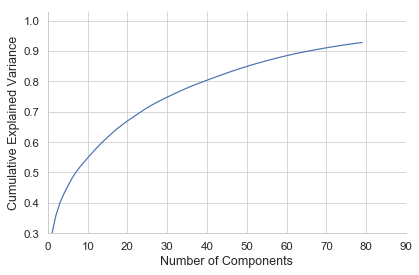

In [315]:
#pca = PCA().fit(X_train)
#fig, ax = plt.subplots()

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.3)  
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
#ax.grid(linestyle='-', linewidth='0.2', color='black')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');
axes = plt.gca()
axes.set_xlim([0,90])
axes.set_ylim([0.3,1.03])
plt.tight_layout()
sns.despine(top=True)
#plt.savefig('Fig1.png', dpi=300)

In [202]:
X_train.shape

(1889, 170)

### KPCA

In [209]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
sc=MinMaxScaler()


X=df2.iloc[:,:]
y=df2.Class
le.fit(y)
y=le.transform(y)

X=X.drop(labels='Class', axis=1)
split = int(len(dfc)*0.80)
sp=split-75
X_train, X_test, y_train, y_test = X[:split], X[sp:], y[:split], y[sp:]
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components=50, kernel="rbf", gamma=0.04)
X_train = rbf_pca.fit_transform(X_train)
X_test = rbf_pca.transform(X_test)

In [210]:
X_train.shape

(1889, 50)

In [211]:
y_train

array([0, 0, 1, ..., 1, 1, 0])

In [59]:
print(rbf_pca.n_components)

60


## LDA

In [603]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
sc=MinMaxScaler()

split = int(len(dfc)*0.80)
sp=split-100
X_train, X_test, y_train, y_test = X[:split], X[sp:], y[:split], y[sp:]
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=50)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [605]:
X_train

array([[-0.71948976],
       [ 0.0882301 ],
       [ 0.71530425],
       ...,
       [ 0.99642856],
       [-0.34510863],
       [ 0.88918394]])

## TRAIN METRICS

In [160]:
X_train.shape

(1889, 170)

In [215]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score

svm_acc=accuracy_score(y_train, svm1.predict(X_train))
gnb_acc=accuracy_score(y_train, gnb.predict(X_train))  
lr_acc=accuracy_score(y_train, lr.predict(X_train))  
rf_acc=accuracy_score(y_train, rf.predict(X_train)) 
xgb_acc=accuracy_score(y_train, xgb.predict(X_train)) 
gbm_acc=accuracy_score(y_train, gbm.predict(X_train)) 
et_acc=accuracy_score(y_train, et.predict(X_train)) 

svm_pr=precision_score(y_train, svm1.predict(X_train),average='binary') 
gnb_pr=precision_score(y_train, gnb.predict(X_train),average='binary') 
lr_pr=precision_score(y_train, lr.predict(X_train),average='binary') 
rf_pr=precision_score(y_train, rf.predict(X_train),average='binary') 
xgb_pr=precision_score(y_train, xgb.predict(X_train),average='binary') 
gbm_pr=precision_score(y_train, gbm.predict(X_train),average='binary') 
et_pr=precision_score(y_train, et.predict(X_train),average='binary') 

svm_f1=f1_score(y_train, svm1.predict(X_train),average='binary') 
gnb_f1=f1_score(y_train, gnb.predict(X_train),average='binary') 
lr_f1=f1_score(y_train, lr.predict(X_train),average='binary') 
rf_f1=f1_score(y_train, rf.predict(X_train),average='binary') 
xgb_f1=f1_score(y_train, xgb.predict(X_train),average='binary') 
gbm_f1=f1_score(y_train, gbm.predict(X_train),average='binary') 
et_f1=f1_score(y_train, et.predict(X_train),average='binary') 

svm_rc=recall_score(y_train, svm1.predict(X_train),average='binary') 
gnb_rc=recall_score(y_train, gnb.predict(X_train),average='binary') 
lr_rc=recall_score(y_train, lr.predict(X_train),average='binary') 
rf_rc=recall_score(y_train, rf.predict(X_train),average='binary') 
xgb_rc=recall_score(y_train, xgb.predict(X_train),average='binary') 
gbm_rc=recall_score(y_train, gbm.predict(X_train),average='binary')  
et_rc=recall_score(y_train, et.predict(X_train),average='binary') 

results=pd.DataFrame({'Algorithm':['SVM','Naive Bayes','Logistic Regression','Random Forest','XGBoost', 'LGBM', 'ExtraTrees'],
                     'Accuracy':[svm_acc,gnb_acc,lr_acc, rf_acc, xgb_acc, gbm_acc, et_acc],
                     'Precision':[svm_pr, gnb_pr, lr_pr, rf_pr, xgb_pr, gbm_pr, et_pr],
                     'Recall':[svm_rc,gnb_rc,lr_rc, rf_rc, xgb_rc, gbm_rc, et_rc],
                     'F1-Score':[svm_f1, gnb_f1, lr_f1, rf_f1, xgb_f1, gbm_f1, et_f1]})
results.set_index('Algorithm', inplace=True)
results

,Accuracy,Precision,Recall,F1-Score
Algorithm,,,,
SVM,0.511911,0.511911,1.000000,0.677171
Naive Bayes,0.566437,0.580435,0.552223,0.565978
Logistic Regression,0.559026,0.554828,0.701138,0.619461
Random Forest,0.606670,0.607900,0.652534,0.629426
XGBoost,0.654844,0.653959,0.691830,0.672362
LGBM,0.725781,0.700268,0.811789,0.751916
ExtraTrees,0.582848,0.559311,0.872802,0.681745


### Stack 

In [276]:
from sklearn.neural_network import MLPClassifier

In [277]:
lr = svm.SVC(kernel='linear',C=0.3,random_state=42)
#clf1 = lightgbm.LGBMClassifier(n_estimators=10,max_depth=20,random_state=42,min_samples_leaf=20)
clf1 = xgboost.XGBClassifier(n_estimators=7,max_depth=3,random_state=42,min_samples_leaf=20)

clf2 = RandomForestClassifier(n_estimators=7, max_depth=3,random_state=42, n_jobs=-1)
#clf3 = MLPClassifier(solver='adam', activation='relu',batch_size=12,
                    #hidden_layer_sizes=(20,12,6,1), random_state=42, shuffle=False)
clf3 = GaussianNB()

#clf1 = LogisticRegression(C=0.4,random_state=42)

from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier
# Initialize Ensemble

model_stack = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr,use_probas=True,
                                average_probas=True)


# Fit the model on our data
model_stack.fit(X_train, y_train)

# Predict training set
model_pred1 = model_stack.predict(X_train)
model_pred2 = model_stack.predict(X_test)

In [278]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
nn_acc1=accuracy_score(y_train, model_pred1)
nn_acc2=accuracy_score(y_test, model_pred2)

nn_pr1=precision_score(y_train, model_pred1) 
nn_pr2=precision_score(y_test, model_pred2) 

nn_f11=f1_score(y_train, model_pred1) 
nn_f12=f1_score(y_test, model_pred2) 

nn_rc1=recall_score(y_train, model_pred1) 
nn_rc2=recall_score(y_test, model_pred2) 

print('Accuracy Train:',nn_acc1,'Accuracy Test:',nn_acc2)
print('Precision Train:',nn_pr1,'Precision Test:',nn_pr2)
print('Recall Train:',nn_rc1,'Recall Test:',nn_rc2)
print('F1 Score Train:',nn_f11,'F1 Score Test:',nn_f12)

Accuracy Train: 0.587083112758073 Accuracy Test: 0.5748175182481752
Precision Train: 0.6103896103896104 Precision Test: 0.5885714285714285
Recall Train: 0.5346432264736298 Recall Test: 0.6983050847457627
F1 Score Train: 0.5700110253583243 F1 Score Test: 0.6387596899224806


In [428]:
X_train.shape

(1894, 42)

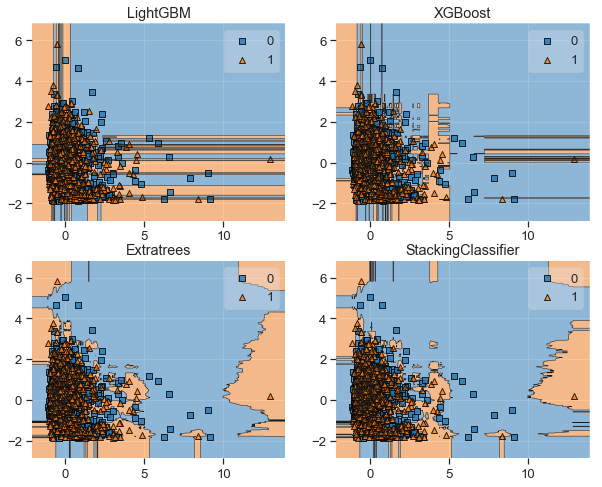

In [340]:
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

X_t=X_train[:,1:3]
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, model_stack], 
                         ['LightGBM', 
                          'XGBoost', 
                          'Extratrees',
                          'StackingClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X_t, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_t, y=y_train, clf=clf)
    plt.title(lab)

## <font color='darkblue'>Tree Based Feature Importance</font>

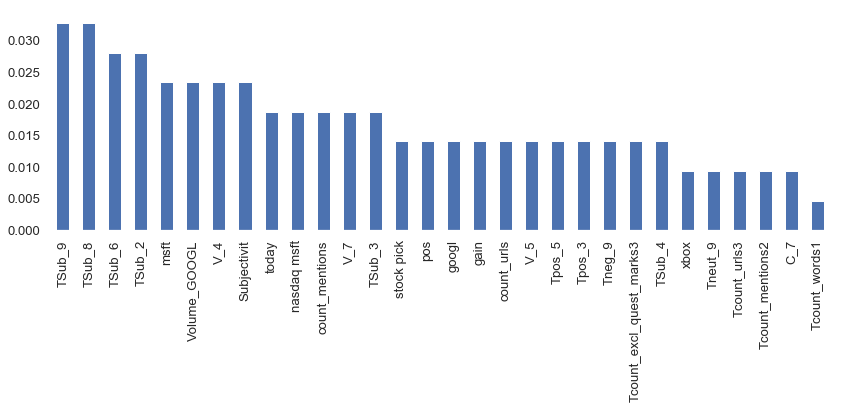

In [74]:
importances = list(zip(xgb.feature_importances_[:30], X.columns[:30]))
importances.sort(reverse=True)
sns.set(style="white")
sns.set(font_scale=1.2)
ax=pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar',
                                                                      figsize=(14,4),
                                                                     legend=False)
ax.set_facecolor('white')
sns.despine(left=True)

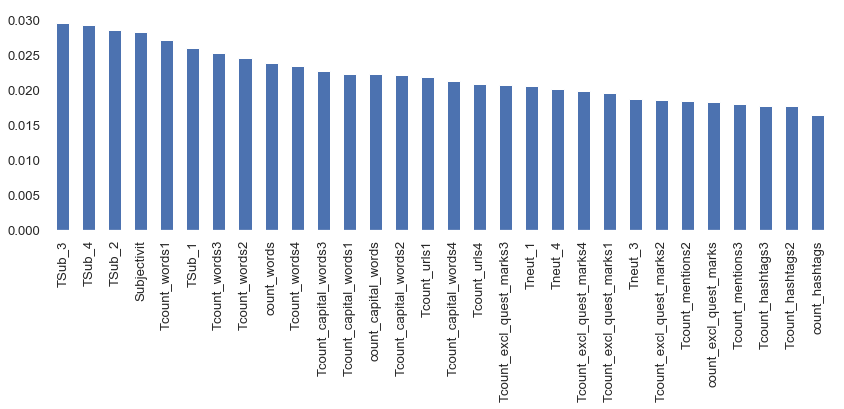

In [297]:
importances = list(zip(rf.feature_importances_[:30], X.columns[:30]))
importances.sort(reverse=True)
sns.set(style="white")
sns.set(font_scale=1.2)
ax=pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar',
                                                                      figsize=(14,4),
                                                                     legend=False)
ax.set_facecolor('white')
sns.despine(left=True)

In [273]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, xgb.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',ascending=False)[:20]

,Gini-importance
rose,0.078125
Open_GOOGL,0.062500
TPol_18,0.046875
day_y,0.046875
TSub_9,0.046875
TPol_13,0.031250
today,0.031250
TPol_5,0.031250
TPol_11,0.031250
Tcount_words3,0.031250


In [432]:
X_train.shape

(2124, 186)

### Reduce Features

In [371]:
a=np.percentile(rf.feature_importances_,60)
print(a)
len(xgb.feature_importances_[xgb.feature_importances_>a])
#rf quantile 68
#xgb quantile 79

0.0010004109529732149


42

In [269]:
def selectKImportance(model, X, k=5):
     return X.iloc[:,model.feature_importances_.argsort()[::-1][:k]]
X=selectKImportance(rf,X,k=30)

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)

print (np.asarray((unique, counts)).T)

## <font color='darkblue'>Keras ANN Model</font>

In [216]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

classifier = Sequential()

classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
classifier.add(Dropout(.5))

#classifier.add(Dense(units = 14, kernel_initializer = 'uniform', activation = 'relu'))
#classifier.add(Dropout(.4))

classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(.4))


classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [217]:
classifier.fit(X_train, y_train, epochs =70, batch_size=16, validation_data=(X_test, y_test), 
               callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)

Train on 1889 samples, validate on 548 samples
Epoch 1/70
1889/1889 [==============================] - 1s 471us/step - loss: 0.6932 - acc: 0.5071 - val_loss: 0.6927 - val_acc: 0.5383
Epoch 2/70
1889/1889 [==============================] - 0s 106us/step - loss: 0.6931 - acc: 0.5119 - val_loss: 0.6925 - val_acc: 0.5383
Epoch 3/70
1889/1889 [==============================] - 0s 97us/step - loss: 0.6930 - acc: 0.5119 - val_loss: 0.6923 - val_acc: 0.5383
Epoch 4/70
1889/1889 [==============================] - 0s 100us/step - loss: 0.6930 - acc: 0.5119 - val_loss: 0.6923 - val_acc: 0.5383
Epoch 5/70
1889/1889 [==============================] - 0s 119us/step - loss: 0.6930 - acc: 0.5119 - val_loss: 0.6922 - val_acc: 0.5383
Epoch 6/70
1889/1889 [==============================] - 0s 112us/step - loss: 0.6929 - acc: 0.5119 - val_loss: 0.6918 - val_acc: 0.5383
Epoch 7/70
1889/1889 [==============================] - 0s 119us/step - loss: 0.6929 - acc: 0.5119 - val_loss: 0.6918 - val_acc: 0.5383
Ep

In [218]:
y_pred = classifier.predict(X_test)
y_pred= np.where(y_pred>0.48,1,0)
y_pred=y_pred.flatten()
y_pred = y_pred.astype(np.int64)

from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
nn_acc=accuracy_score(y_test, y_pred)
nn_pr=precision_score(y_test, y_pred) 
nn_f1=f1_score(y_test, y_pred) 
nn_rc=recall_score(y_test, y_pred) 

print('Accuracy:',nn_acc)
print('Precision:',nn_pr)
print('Recall:',nn_rc)
print('F1 Score:',nn_f1)

Accuracy: 0.5456204379562044
Precision: 0.5508849557522124
Recall: 0.8440677966101695
F1 Score: 0.6666666666666666


In [219]:
y_pred = classifier.predict(X_train)
y_pred= np.where(y_pred>0.48,1,0)
y_pred=y_pred.flatten()
y_pred = y_pred.astype(np.int64)

from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
nn_acc=accuracy_score(y_train, y_pred)
nn_pr=precision_score(y_train, y_pred) 
nn_f1=f1_score(y_train, y_pred) 
nn_rc=recall_score(y_train, y_pred) 

print('Accuracy:',nn_acc)
print('Precision:',nn_pr)
print('Recall:',nn_rc)
print('F1 Score:',nn_f1)

Accuracy: 0.5510852302805718
Precision: 0.5402298850574713
Recall: 0.8262668045501551
F1 Score: 0.6533115290269829


In [220]:
X_train.shape

(1889, 50)

### ROC Curve

0.535996400359964


Text(0.5, 0, 'False Positive Rate')

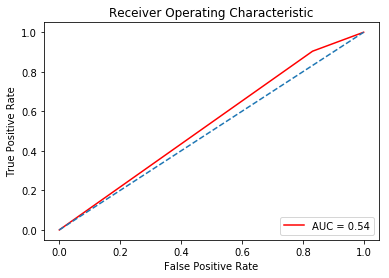

In [252]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## <font color='darkblue'>Technical Indicators</font>

In [442]:
dfse['H-L'] = dfse['High_GOOGL'] - dfse['Low_GOOGL']
dfse['O-C'] = dfse['Close_GOOGL'] - dfse['Open_GOOGL']

dfse['3day MA'] = dfse['Close_GOOGL'].shift(1).rolling(window = 3).mean()
dfse['10day MA'] = dfse['Close_GOOGL'].shift(1).rolling(window = 10).mean()
dfse['30day MA'] = dfse['Close_GOOGL'].shift(1).rolling(window = 30).mean()
dfse['Std_dev']= dfse['Close_GOOGL'].rolling(5).std()

dfse['RSI'] = talib.RSI(dfse['Close_GOOGL'].values, timeperiod = 9)

dfse['OBV'] = talib.OBV(dfse['Close_GOOGL'].values, dfse['Volume_GOOGL'].values)

dfse['TRange'] = talib.TRANGE(dfse['High_GOOGL'].values, dfse['Low_GOOGL'].values,
                            dfse['Close_GOOGL'].values)


dfse['Ult'] = talib.ULTOSC(dfse['High_GOOGL'].values, dfse['Low_GOOGL'].values,
                          dfse['Close_GOOGL'].values, timeperiod1=7, 
                          timeperiod2=14, timeperiod3=28)

dfse['Williams %R'] = talib.WILLR(dfse['High_GOOGL'].values, 
                                 dfse['Low_GOOGL'].values, dfse['Close_GOOGL'].values, 7)

In [443]:
dfse.dropna(inplace=True)
dfse.head(2)

,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Polarity,Subjectivity,Class,quarter,month,...,O-C,3day MA,10day MA,30day MA,Std_dev,RSI,OBV,TRange,Ult,Williams %R
DateTime,,,,,,,,,,,,,,,,,,,,,
2007-02-20,39.900002,40.439999,39.869999,40.330002,4679000.0,0.233333,0.20000,up,1,2,...,0.430000,39.836667,38.798,37.974667,0.629977,69.426987,18791200.0,0.570000,59.621196,-5.288322
2007-02-21,40.130001,41.740002,40.000000,41.509998,8903400.0,0.205311,0.43327,down,1,2,...,1.379997,40.176667,39.092,38.022333,0.794323,76.715781,27694600.0,1.740002,65.954215,-6.804850


## <font color='darkblue'>Text Features</font>

To analyze the text variable we create a class **TextCounts**. In this class we compute some basic statistics on the text variable. This class can be used later in a Pipeline, as well.

* **count_words** : number of words in the tweet
* **count_mentions** : referrals to other Twitter accounts, which are preceded by a @
* **count_hashtags** : number of tag words, preceded by a #
* **count_capital_words** : number of uppercase words, could be used to *"shout"* and express (negative) emotions
* **count_excl_quest_marks** : number of question or exclamation marks
* **count_urls** : number of links in the tweet, preceded by http(s)
* **count_emojis** : number of emoji, which might be a good indication of the sentiment

In [69]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

In [70]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        dt_time=df2.DateTime

        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                           , 'DateTime':dt_time
                          })
        
        return df

In [71]:
dfo['Text'] = dfo['Text'].astype(object)

In [72]:
#dfo=pd.read_excel('microsoft_all_dec10.xlsx')
df2 = dfo[['Text','DateTime']]
df2['Text'] = df2['Text'].astype(object)
#df2['Text'] =df2.Text.str.lower()
df2.reset_index(inplace=True)
del(df2['index'])
df2['DateTime'] = pd.to_datetime(df2['DateTime'],errors='coerce')
df2['DateTime']=df2.DateTime.dt.date
print(df2.shape)

def preprocess(tweet):
    if type(tweet)!=type(2.0):
        #tweet.startswith('a')
        tweet = tweet
    else:
        tweet=''
    return tweet

df2['Text']=df2.Text.apply(preprocess)
df2['Text'].astype(str);
print(df2.shape)

(174310, 2)
(174310, 2)


In [73]:
df2.head(2)

,Text,DateTime
0,"@QOTD: Buy Microsoft stock immediately. Sell around 1998, and buy stock in this little company called Google.",2007-01-30
1,"OK, I went and did it - I invested in Yahoo. At worst, their stock price will hopefully come up if someone (Microsoft?) eats them.",2007-04-20


In [74]:
df2.dropna(inplace=True)
tc = TextCounts()
df_eda = tc.fit_transform(df2.Text)

In [16]:
#df_eda['DateTime']=df_eda.DateTime.dt.date
dft=df_eda.groupby(['DateTime']).sum()
dft.index = pd.to_datetime(dft.index)

In [17]:
for obs in range(1,5):
    dft['Tcount_words'+str(obs)]=dft.count_words.shift(obs)
    dft['Tcount_mentions'+str(obs)]=dft.count_mentions.shift(obs)
    dft['Tcount_hashtags'+str(obs)]=dft.count_hashtags.shift(obs)
    dft['Tcount_capital_words'+str(obs)]=dft.count_capital_words.shift(obs)
    dft['Tcount_excl_quest_marks'+str(obs)]=dft.count_excl_quest_marks.shift(obs)
    dft['Tcount_urls'+str(obs)]=dft.count_urls.shift(obs)

In [18]:
dft.dropna(inplace=True)
dft.head(2)

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,Tcount_words1,Tcount_mentions1,Tcount_hashtags1,...,Tcount_hashtags3,Tcount_capital_words3,Tcount_excl_quest_marks3,Tcount_urls3,Tcount_words4,Tcount_mentions4,Tcount_hashtags4,Tcount_capital_words4,Tcount_excl_quest_marks4,Tcount_urls4
DateTime,,,,,,,,,,,,,,,,,,,,,
2007-05-04,105,2,0,0,3,0,0,21.0,0.0,0.0,...,0.0,0.0,1.0,0.0,17.0,1.0,0.0,0.0,0.0,0.0
2007-05-18,17,0,0,0,0,0,0,105.0,2.0,0.0,...,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,1.0,0.0


In [100]:
df_eda['count_urls'].sum()

144454

In [75]:
inc={'count_mentions':'Mentions @','count_hashtags':'Hashtag #','count_capital_words':'Capital',
    'count_excl_quest_marks':'! or ?','count_urls':'URL'}

In [101]:
a=pd.DataFrame(df_eda.sum(), columns=['Count'])
a.loc['count_capital_words','Count']=199173
a.head(7)

,Count
count_words,4113071
count_mentions,28323
count_hashtags,123767
count_capital_words,199173
count_excl_quest_marks,56352
count_urls,144454
count_emojis,1044


<class 'pandas.core.frame.DataFrame'>


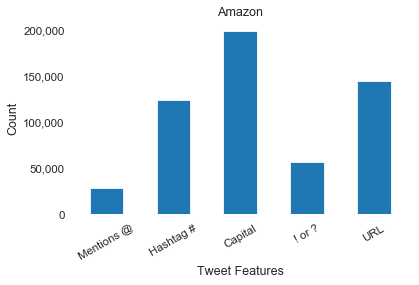

In [102]:
#a=pd.DataFrame(df_eda.sum(), columns=['Count'])
a['Features'] = a.index
a=a.iloc[1:6,:]
print(type(a))
a['Features']=a.Features.map(inc)
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  
ax=a.plot.bar(x='Features',y='Count',color='#1f77b4',width=0.5,legend=False, figsize=(6,4))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.xticks(rotation=30)
plt.xlabel('Tweet Features')
plt.ylabel('Count')
plt.box(False)
plt.tight_layout()
plt.title('Amazon')
plt.savefig('Fig2.3.png', bbox_inches='tight', dpi=300)

In [19]:
#dff=pd.merge(dfse,dft, on='DateTime', how='left')
dff=pd.merge(dfc,dft, on='DateTime', how='left')
#dff=pd.merge(dfm,dft, on='DateTime', how='left')
dff.dropna(inplace=True)
print(dff.shape)
dff.head(1)

(2362, 101)


,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Class,quarter,month,day,Year,...,Tcount_hashtags3,Tcount_capital_words3,Tcount_excl_quest_marks3,Tcount_urls3,Tcount_words4,Tcount_mentions4,Tcount_hashtags4,Tcount_capital_words4,Tcount_excl_quest_marks4,Tcount_urls4
DateTime,,,,,,,,,,,,,,,,,,,,,
2008-10-29,21.639999,23.209999,21.34,17.906729,134088800.0,down,4,10,29,2008,...,0.0,0.0,5.0,1.0,40.0,0.0,0.0,0.0,0.0,1.0


## <font color='darkblue'>N-Grams and TF-IDF</font>

In [20]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [21]:
def preprocess(tweet):
    if type(tweet)!=type(2.0):
        #tweet.startswith('a')
        tweet = tweet
    else:
        tweet=''
    return tweet

dft=dfo.loc[:,['Text','DateTime']]
dft['DateTime'] = pd.to_datetime(dft['DateTime'],errors='coerce')
dft['DateTime']=dft.DateTime.dt.date
dft['Text']=dft.Text.apply(preprocess)
dft['Text'].astype(str);
print(dft.shape)

(167142, 2)


In [22]:
ct = CleanText()
df_clean = ct.fit_transform(dft.Text)
df_clean.shape

(167142,)

In [23]:
s1=dft.DateTime
data=pd.DataFrame(dict(Text = df_clean, DateTime = s1)).reset_index()
print(data.shape)
data=data.drop(data[data.Text==''].index)
print(data.shape)

(167142, 3)
(167142, 3)


In [24]:
data.head(2)

,index,Text,DateTime
0,0,buy microsoft stock immedi sell around buy stock littl compani call googl,2007-01-30
1,1,ok went invest yahoo worst stock price hope come someon microsoft eat,2007-04-20


In [46]:
# Remooving Amazon
#data['Text']=data.Text.str.replace('apple','')

### <font color='darkblue'> 1. Count Vectorizer </font>

* max_df = 0.50 means "ignore terms that appear in more than 50% of the documents"

* min_df = 0.01 means "ignore terms that appear in less than 1% of the documents"

In [25]:
cv=CountVectorizer(min_df=0.01, max_df=0.9,max_features=70, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=(1,2),
                            stop_words = "english")


X=cv.fit_transform(data.Text)
ss=pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
ss['DateTime']=data.DateTime.values
print(ss.shape)
ss.head(3)

(167142, 71)


,aapl,alert,amazon,amzn,analysi,appl,buy,cloud,com,compani,...,trade,twitter,twitter com,updat,valu,week,window,xbox,year,DateTime
0,0,0,0,0,0,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,2007-01-30
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2007-04-20
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2007-04-27


### <font color='darkblue'> 2. TF-IDF </font>

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tf_idf=TfidfVectorizer(min_df=0.001, max_df=0.9,max_features=60, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=(1,2),
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english")


X=tf_idf.fit_transform(data.Text)
ss=pd.DataFrame(X.toarray(), columns=tf_idf.get_feature_names())
ss['DateTime']=data.DateTime.values
ss.head(3)

,book,card,com,deal,gift,kindl,new,twitter,win,DateTime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-01-01
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-01-01
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-01-02


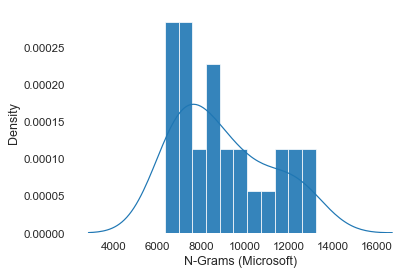

In [34]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.3) 
ssx=ss.iloc[:,:71]
ad=ssx.sum()
ad=pd.DataFrame(ad, columns=['Count'])

b1=ad['Count'].quantile(0.90)
b2=ad['Count'].quantile(0.5)
ad=ad[(ad["Count"] < b1) & (ad["Count"] > b2)]

sns.distplot(ad, bins=11, norm_hist=True, kde=True, color='#1f77b4',hist_kws=dict(alpha=0.9));
plt.xlabel('N-Grams (Microsoft)')
plt.ylabel('Density')
plt.box(False)
plt.tight_layout()
plt.savefig('Fig2.4.png', bbox_inches='tight', dpi=300)

In [63]:
dff.shape, ss1.shape

((2827, 45), (4113, 70))

In [26]:
# Merge
ss1=ss.groupby(['DateTime']).sum()
ss1.index=pd.to_datetime(ss1.index)
df2=pd.merge(dff,ss1, on='DateTime', how='left')
df2.dropna(inplace=True)
df2.isnull().sum()
df2.head(2)

,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Class,quarter,month,day_x,Year,...,today,trade,twitter,twitter com,updat,valu,week,window,xbox,year
DateTime,,,,,,,,,,,,,,,,,,,,,
2008-10-29,21.639999,23.209999,21.340000,17.906729,134088800.0,down,4,10,29,2008,...,0,0,0,0,0,0,0,2,0,0
2008-10-30,23.129999,23.969999,22.700001,17.829216,111701800.0,down,4,10,30,2008,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df2.shape

(2362, 171)

## 3D Plot (Features, Models, Accuracy)

In [2]:
df=pd.read_excel('Stocks_gr.xlsx', sheet_name='ss1')
df.head(2)

,X,Y,Z
0,1,1,0.458716
1,2,1,0.457454


In [94]:
df.Z.max()

0.627871

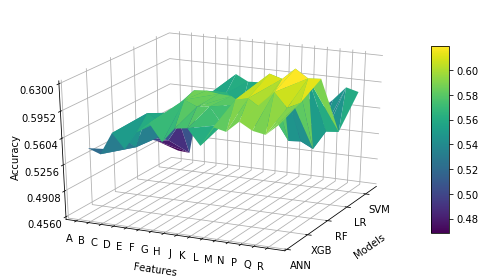

In [279]:
# library
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
import pandas as pd
import seaborn as sns
 

# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes

df['Y']=pd.Categorical(df['Y'])
df['Y']=df['Y'].cat.codes


# Make the plot
fig = plt.figure(figsize=(7,4))

ax = fig.gca(projection='3d')

# to Add a color bar which maps values to colors.
ax.plot_trisurf(df['Y'], df['X'], df['Z'], lw=0.6,cmap=plt.cm.viridis, linewidth=0.2)
#ax.plot_surface(X, Y, Z, rstride=10, cstride=10, color='orangered', edgecolors='k', lw=0.6)

fig.colorbar(surf, shrink=0.7, aspect=10,fraction=0.1,pad=0.0001)

ax.get_xaxis().set_visible(False)
ax.grid(False)

plt.xticks([1, 2, 3, 4, 5], ['SVM', 'LR', 'RF','XGB','ANN'])
plt.yticks([1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15,16], ['A', 'B', 'C','D','E','F','G','H','J',
                                                         'K','L','M','N','P','Q','R'])
#ax.set_zticks([])
ax.set_zlim(0.456, 0.63)
ax.w_zaxis.set_major_locator(LinearLocator(6))

plt.xlim([0.5, 5])
plt.ylim([0.5, 17])

sns.despine(left=True)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_label('Accuracy')

ax.view_init(25,25)
ax.grid(which='both')
plt.xlabel('Models', labelpad=10)
plt.ylabel('Features', labelpad=10)

ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('Accuracy', fontsize=10,rotation=90)

plt.tight_layout()
plt.savefig('Fig2.51.png', bbox_inches='tight', dpi=300)

## Granger Causality Tests

In [31]:
dfa=pd.read_csv('microsoft_num.csv')
dfa['DateTime']=pd.to_datetime(dfa['Date'])
dfa.set_index('DateTime', inplace=True)
del(dfa['Date'])
del(dfa['Close'])
dfa=dfa[(dfa.index>='2007-01-01')&(dfa.index<'2018-11-02')]
dfa = dfa[['Open', 'High', 'Low', 'Volume','Adj Close']]

In [17]:
dfo=pd.read_excel('microsoft_all_dec10.xlsx')
dfo['Text'] = dfo['Text'].astype(object)
dfo['Text'] =dfo.Text.str.lower()
dfo['Processed_text']=dfo.Text.apply(preprocess)
dfo['pol_sub']=dfo.Processed_text.apply(lambda tweet:TextBlob(tweet).sentiment)
dfo['Polarity']=dfo['pol_sub'].apply(lambda x:x[0])
dfo['Subjectivity']=dfo['pol_sub'].apply(lambda x: x[1])
del (dfo['pol_sub'])
df1=dfo.copy(deep=True)
df1=df1.loc[:,['DateTime','Polarity','Subjectivity']]
df1['DateTime'] = pd.to_datetime(df1['DateTime'],errors='coerce')
df1['DateTime']=df1.DateTime.dt.date

def label (row):
    if row['Polarity'] >= 0.2:
        return 'pos'
    elif row['Polarity']<=-0.05:
        return 'neg'
    else:
        return 'neut'

df1['Sentiment'] = df1.apply (lambda row: label(row),axis=1)
print(df1.Sentiment.value_counts())


aa=df1.loc[:,['DateTime','Subjectivity']]
aa=aa.groupby('DateTime').mean()

gg=df1.groupby(['DateTime', 'Sentiment']).size().reset_index(name='count')
gg=gg.pivot_table(index='DateTime',columns='Sentiment',aggfunc='sum')
gg.fillna(0, inplace=True)
gg.columns = gg.columns.droplevel(level=0)
gg['Subjectivit']=aa
print(gg.shape)

gg.index = pd.to_datetime(gg.index)
gg.columns = ['neg', 'neut','pos','subj']

dfc=pd.merge(dfa,gg, on='DateTime', how='left')
dfc=dfc.dropna()

neut    118786
pos      39577
neg      15947
Name: Sentiment, dtype: int64
(3829, 4)


In [32]:
df1=dfo.copy(deep=True)
df1=df1.loc[:,['DateTime','Polarity','Subjectivity']]
df1['DateTime'] = pd.to_datetime(df1['DateTime'],errors='coerce')
df1['DateTime']=df1.DateTime.dt.date
print('Tweets Dataframe',df1.shape)
df1=df1.groupby('DateTime').mean()
df1.index = pd.to_datetime(df1.index)
df2=pd.merge(dfa,df1, on='DateTime', how='left')
df2.dropna(inplace=True)
print('Merged Dataframe',df2.shape)
df2.head()

Tweets Dataframe (167142, 3)
Merged Dataframe (2665, 7)


,Open,High,Low,Volume,Adj Close,Polarity,Subjectivity
DateTime,,,,,,,
2007-06-11,29.940001,30.250000,29.930000,48467400,22.848265,0.27500,0.875
2007-07-06,29.910000,30.040001,29.660000,57541000,22.810207,0.20000,0.400
2007-07-23,31.360001,31.520000,31.120001,48910600,23.738750,-0.09375,0.250
2007-07-26,30.240000,30.530001,29.510000,87025300,22.817822,0.00000,0.000
2007-08-01,28.950001,29.549999,28.820000,80006300,22.300270,0.10000,0.400


In [33]:
# Dickey Fuller
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

   
    #Perform Dickey-Fuller test:
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [35]:
# Make Stationary
tslog=np.log(df2['Adj Close'])
tslog = tslog - tslog.shift(2)
tslog.dropna(inplace=True)
test_stationarity(tslog)
df2=df2.iloc[3:,:]
df2['tslog']=tslog

<Results of Dickey-Fuller Test>
Test Statistic                -9.722969e+00
p-value                        9.435982e-17
#Lags Used                     2.700000e+01
Number of Observations Used    2.632000e+03
Critical Value (1%)           -3.432837e+00
Critical Value (5%)           -2.862639e+00
Critical Value (10%)          -2.567355e+00
dtype: float64


In [22]:
from decimal import Decimal
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

format_e(Decimal('-9.612912e+00'))

'-9.612912E+00'

In [36]:
ar1=df2['tslog']
ar2=df2['Polarity']
x = np.array([ar1, ar2], np.float)
x = x.transpose()
import statsmodels.tsa.stattools as sm
lag = 30
sm.grangercausalitytests(x, lag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0731  , p=0.0437  , df_denom=2655, df_num=1
ssr based chi2 test:   chi2=4.0777  , p=0.0435  , df=1
likelihood ratio test: chi2=4.0746  , p=0.0435  , df=1
parameter F test:         F=4.0731  , p=0.0437  , df_denom=2655, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2471  , p=0.0390  , df_denom=2652, df_num=2
ssr based chi2 test:   chi2=6.5065  , p=0.0386  , df=2
likelihood ratio test: chi2=6.4985  , p=0.0388  , df=2
parameter F test:         F=3.2471  , p=0.0390  , df_denom=2652, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2496  , p=0.0806  , df_denom=2649, df_num=3
ssr based chi2 test:   chi2=6.7666  , p=0.0797  , df=3
likelihood ratio test: chi2=6.7580  , p=0.0800  , df=3
parameter F test:         F=2.2496  , p=0.0806  , df_denom=2649, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0348  , p=0.

ssr based F test:         F=1.4142  , p=0.0702  , df_denom=2571, df_num=29
ssr based chi2 test:   chi2=41.9528 , p=0.0567  , df=29
likelihood ratio test: chi2=41.6217 , p=0.0607  , df=29
parameter F test:         F=1.4142  , p=0.0702  , df_denom=2571, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=1.3713  , p=0.0863  , df_denom=2568, df_num=30
ssr based chi2 test:   chi2=42.1155 , p=0.0700  , df=30
likelihood ratio test: chi2=41.7817 , p=0.0747  , df=30
parameter F test:         F=1.3713  , p=0.0863  , df_denom=2568, df_num=30


{1: ({'ssr_ftest': (4.073102063972225, 0.04367157479455725, 2655.0, 1),
   'ssr_chi2test': (4.077704439185753, 0.04345265426556972, 1),
   'lrtest': (4.074579780215572, 0.043533092974824564, 1),
   'params_ftest': (4.073102063972237, 0.04367157479455725, 2655.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.2471187002965958, 0.03904074655638248, 2652.0, 2),
   'ssr_chi2test': (6.506481437924626, 0.03864875490977949, 2),
   'lrtest': (6.49852785963958, 0.038802758876365424, 2),
   'params_ftest': (3.2471187002966175, 0.03904074655638248, 2652.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.2495799756196826, 0.08061224725639972, 2649.0, 3),
   'ssr_chi2test': (6.766573516699748, 0.07972199237424667, 3),
   'lrtest': (6.757968678615725, 0.08002558468966013, 3),
   'params_ftest': (2.2495799756199406, 0.08061224725635503, 2649.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

In [30]:
ar1=dfc1['tslog']
ar2=dfc1['neut']
x = np.array([ar1, ar2], np.float)
x = x.transpose()
import statsmodels.tsa.stattools as sm
lag = 20
sm.grangercausalitytests(x, lag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1371  , p=0.7112  , df_denom=2667, df_num=1
ssr based chi2 test:   chi2=0.1373  , p=0.7110  , df=1
likelihood ratio test: chi2=0.1372  , p=0.7110  , df=1
parameter F test:         F=0.1371  , p=0.7112  , df_denom=2667, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1486  , p=0.8619  , df_denom=2664, df_num=2
ssr based chi2 test:   chi2=0.2977  , p=0.8617  , df=2
likelihood ratio test: chi2=0.2977  , p=0.8617  , df=2
parameter F test:         F=0.1486  , p=0.8619  , df_denom=2664, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1679  , p=0.9181  , df_denom=2661, df_num=3
ssr based chi2 test:   chi2=0.5050  , p=0.9178  , df=3
likelihood ratio test: chi2=0.5049  , p=0.9178  , df=3
parameter F test:         F=0.1679  , p=0.9181  , df_denom=2661, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1352  , p=0.

{1: ({'ssr_ftest': (0.13709874659683915, 0.7112118595992137, 2667.0, 1),
   'ssr_chi2test': (0.13725296340965898, 0.7110273561181069, 1),
   'lrtest': (0.1372494357456162, 0.7110309029082307, 1),
   'params_ftest': (0.13709874659641794, 0.7112118595992137, 2667.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.1485717743774239, 0.8619452812874474, 2664.0, 2),
   'ssr_chi2test': (0.2977012506106189, 0.8616978211349391, 2),
   'lrtest': (0.29768464899098035, 0.8617049739543612, 2),
   'params_ftest': (0.14857177437740754, 0.8619452812874474, 2664.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.16787606416593287, 0.9180832595047286, 2661.0, 3),
   'ssr_chi2test': (0.504953031786594, 0.9178019124787885, 3),
   'lrtest': (0.5049052534122893, 0.9178124348273159, 3),
   'params_ftest': (0.16787606416594328, 0.9180832595047286, 2661.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

In [20]:
test_stationarity(dfc['Adj Close'])

<Results of Dickey-Fuller Test>
Test Statistic                    2.031767
p-value                           0.998713
#Lags Used                       15.000000
Number of Observations Used    2656.000000
Critical Value (1%)              -3.432814
Critical Value (5%)              -2.862629
Critical Value (10%)             -2.567350
dtype: float64


### Topic Modeling

In [9]:
doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father."
doc2 = "My father spends a lot of time driving my sister around to dance practice."
doc3 = "Doctors suggest that driving may cause increased stress and blood pressure."
doc4 = "Sometimes I feel pressure to perform well at school, but my father never seems to drive my sister to do better."
doc5 = "Health experts say that Sugar is not good for your lifestyle."

# compile documents
doc_complete = [doc1, doc2, doc3, doc4, doc5]

In [11]:
print(type(doc_complete))
doc_complete

<class 'list'>


['Sugar is bad to consume. My sister likes to have sugar, but not my father.',
 'My father spends a lot of time driving my sister around to dance practice.',
 'Doctors suggest that driving may cause increased stress and blood pressure.',
 'Sometimes I feel pressure to perform well at school, but my father never seems to drive my sister to do better.',
 'Health experts say that Sugar is not good for your lifestyle.']

In [16]:
doc_complete=list(dfo.Text[:10000])
doc_complete

['@qotd: buy microsoft stock immediately. sell around 1998, and buy stock in this little company called google.',
 'ok, i went and did it - i invested in yahoo. at worst, their stock price will hopefully come up if someone (microsoft?) eats them.',
 "wishing i'd bought microsoft stock rather than yahoo.   but i still like yahoo...i think...",
 'sad that my tfsm stocks are now $ with msft buying them - ceo just sold about 750k worth of stock last week',
 '@frankmeeuwsen: we asked about the msft deal and they responded that this happens every year when the stock is low. no deal yet.',
 '@ml - rumors of may-li khoe returning to msft/yhoo, stock takes a dive',
 'just heard about the microsoft-yahoo... whatever-it-is. looking into selling off yahoo stock...',
 'whoa woke up to a crazy news... msft + yhoo? my stock is up :)',
 'microsoft wants to buy yahoo, stock up by 18%. who has more info?',
 'wow, yhoo stock up 18% today on the microsoft rumors.',
 'synergies make sense in microsoft / ya

In [19]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]

# Importing Gensim
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean )

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=20, update_every=500)

In [20]:
print(ldamodel.print_topics(num_topics=3, num_words=5))

[(3, '0.079*"stock" + 0.052*"microsoft" + 0.023*"yahoo" + 0.019*"msft" + 0.013*"buy"'), (1, '0.077*"stock" + 0.043*"microsoft" + 0.019*"msft" + 0.014*"microsofts" + 0.014*"buy"'), (0, '0.071*"stock" + 0.051*"microsoft" + 0.025*"msft" + 0.018*"rms" + 0.016*"dynamic"')]


In [35]:
#spacy
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

In [60]:
doc_set=dfo.Processed_text[25000:50000]

#don't want puncuations, spaces as tokens
tokenize_blacklist = ['PUNCT', 'SPACE']

texts = []

for doc in doc_set:
    # print(doc)
    
    # putting our three steps together
    
    #1. Tokenize
    doc_sp = nlp(doc)
    tokens = [token.text.lower() for token in doc_sp if token.pos_ not in tokenize_blacklist]
    #tokens = [token.text.lower() for token in doc_sp]
    if(len(tokens) < 3):
        continue
    #2. remove stop words
    stopped_tokens = [token for token in tokens if not token in spacy_stopwords]
    
    #3. lemmetize
    lemmed_tokens = []
    for stopped_token in stopped_tokens:
        lemmed_nlp = nlp(stopped_token)
        lemmed_token = lemmed_nlp[0].lemma_
        lemmed_tokens.append(lemmed_token)
    
    
    # add tokens to list, let's start with stopped_tokens, lemmitization is messing up.
    # for loop so that we don't get list of lists
    for stopped_token in stopped_tokens:
        texts.append(stopped_tokens)

#### Create bigram and trigram models

In [61]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
#def remove_stopwords(texts):
#    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [62]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(texts, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[texts], threshold=30)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[texts[0]]])

['best', 'stock', 'pick', 'bac', 'mspd']


In [63]:
# Form Bigrams
data_words_bigrams = make_bigrams(texts)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_words_bigrams[:1])

[['best', 'stock', 'pick', 'bac', 'mspd']]


#### Create the Dictionary and Corpus needed for Topic Modeling

In [64]:
candidate_text = texts # unigrams :Perplexity:  -4.377417073025684 Coherence Score:  0.7472006215139164
#candidate_text = data_words_bigrams ## Perplexity:  -4.377417073025684  Coherence Score:  0.7472006215139164

# Create Dictionary
id2word = corpora.Dictionary(candidate_text)

# Create Corpus
texts = candidate_text

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


[[('bac', 1), ('best', 1), ('mspd', 1), ('pick', 1), ('stock', 1)]]

In [65]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [66]:
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.281*"stock" + 0.245*"microsoft" + 0.085*"amazon" + 0.053*"live" + '
  '0.049*"window" + 0.014*"news" + 0.011*"apple" + 0.010*"new" + 0.008*"dtn" + '
  '0.008*"office"'),
 (1,
  '0.189*"xbox" + 0.130*"game" + 0.046*"pc" + 0.035*"analysis" + '
  '0.028*"flight" + 0.022*"simulator" + 0.021*"decade" + 0.020*"edition" + '
  '0.014*"sale" + 0.013*"today"'),
 (2,
  '0.050*"time" + 0.046*"tech" + 0.038*"simulator" + 0.036*"build" + '
  '0.036*"flight" + 0.033*"edition" + 0.022*"final" + 0.022*"tease" + '
  '0.021*"wavering" + 0.015*"tablet"'),
 (3,
  '0.165*"point" + 0.106*"gold" + 0.054*"market" + 0.023*"edition" + '
  '0.021*"year" + 0.017*"simulator" + 0.013*"tease" + 0.013*"final" + '
  '0.012*"wavering" + 0.012*"apps"'),
 (4,
  '0.054*"msft" + 0.052*"apps" + 0.050*"buy" + 0.041*"high" + 0.025*"final" + '
  '0.025*"tease" + 0.024*"wavering" + 0.019*"finally" + 0.016*"corp" + '
  '0.014*"facebook"')]


In [49]:
# Compute Perplexity


from gensim import corpora, models
from gensim.models import CoherenceModel
import gensim


print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=candidate_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.71656554584116

Coherence Score:  0.47474476694518986


#### How to find the optimal number of topics for LDA?

In [50]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word,  num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10,  alpha='auto',  per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

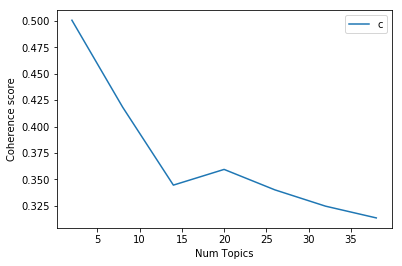

In [51]:
#Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=candidate_text, start=2, limit=40, step=6)

# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()